In [1]:
# uncomment the next line if you want to delete an existing models directory
!rm -rf ./models/

# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 3909, done.
remote: Counting objects: 100% (3909/3909), done.
remote: Compressing objects: 100% (3015/3015), done.
remote: Total 3909 (delta 1129), reused 2002 (delta 841), pack-reused 0
Receiving objects: 100% (3909/3909), 49.65 MiB | 15.82 MiB/s, done.
Resolving deltas: 100% (1129/1129), done.


In [2]:
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696986 sha256=24684d19461ab68fdeb22584211c7f13ee982b3e5aa0981a9f4b3208264b446f
  Stored in directory: /tmp/pip-ephem-wheel-cache-77ztowr1/wheels/53/dd/70/2de274d6c443c69d367bd6a5606f95e5a6df61aacf1435ec0d
Successfully built object-detection
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [3]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
pip install -U numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.24.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


In [5]:
### START CODE HERE (Replace Instances of `None` with your code) ###
# import the label map utility module
from object_detection.utils import label_map_util

# import module for reading and updating configuration files.
from object_detection.utils import config_util

# import module for visualization. use the alias `viz_utils`
from object_detection.utils  import visualization_utils as viz_utils

# import module for building the detection model
from object_detection.builders import model_builder
### END CODE HERE ###

# import module for utilities in Colab
from object_detection.utils import colab_utils

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """

    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size

    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """

    image_np_with_annotations = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)

    if image_name:
        plt.imsave(image_name, image_np_with_annotations)

    else:
        plt.imshow(image_np_with_annotations)

In [13]:
# uncomment the next 2 lines if you want to delete an existing zip and training directory
#rm training-zombie.zip
#rm -rf ./training

# download the images
!wget --no-check-certificate \
   https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training-zombie.zip \
  -O ./training-zombie.zip

# unzip to a local directory
local_zip = './training-cows.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

--2023-06-14 12:31:07--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training-zombie.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-06-14 12:31:07 ERROR 404: Not Found.



./training/training_cows/training-cow1.jpg
./training/training_cows/training-cow2.jpg
./training/training_cows/training-cow3.jpg
./training/training_cows/training-cow4.jpg
./training/training_cows/training-cow5.jpg


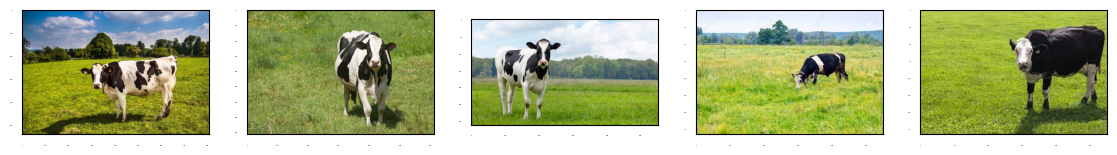

In [15]:
%matplotlib inline

### START CODE HERE (Replace Instances of `None` with your code) ###

# assign the name (string) of the directory containing the training images
train_image_dir = './training/training_cows'

# declare an empty list
train_images_np = []

# run a for loop for each image
for i in range(1, 6):

    # define the path (string) for each image
    image_path = os.path.join("./training/training_cows/training-cow" + str(i) + ".jpg")
    print(image_path)

    # load images into numpy arrays and append to a list
    train_images_np.append(load_image_into_numpy_array(image_path))
### END CODE HERE ###

# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot images
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 5, idx+1)
    plt.imshow(train_image_np)

plt.show()

In [24]:
# Define the list of ground truth boxes
gt_boxes = []

In [27]:
# Option 1: draw your own ground truth boxes

# annotate the training images
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [30]:
# Option 1: draw your own ground truth boxes
# TEST CODE:
try:
  assert(len(gt_boxes) == 5), "Warning: gt_boxes is empty. Did you click `submit`?"

except AssertionError as e:
  print(e)

# checks if there are boxes for all 5 images
for gt_box in gt_boxes:
    try:
      assert(gt_box is not None), "There are less than 5 sets of box coordinates. " \
                                  "Please re-run the cell above to draw the boxes again.\n" \
                                  "Alternatively, you can run the next cell to load pre-determined " \
                                  "ground truth boxes."

    except AssertionError as e:
        print(e)
        break

In [ ]:
# Option 2: use given ground truth boxes
# set this to `True` if you want to override the boxes you drew
override = False

# bounding boxes for each of the 5 zombies found in each image.
# you can use these instead of drawing the boxes yourself.
ref_gt_boxes = [
        np.array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
        np.array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
        np.array([[0.40833333, 0.18288394, 0.945, 0.34818288]]),
        np.array([[0.16166667, 0.61899179, 0.8, 0.91910903]]),
        np.array([[0.28833333, 0.12543962, 0.835, 0.35052755]]),
      ]

# if gt_boxes is empty, use the reference
if not gt_boxes or override is True:
  gt_boxes = ref_gt_boxes

# if gt_boxes does not contain 5 box coordinates, use the reference
for gt_box in gt_boxes:
    try:
      assert(gt_box is not None)

    except:
      gt_boxes = ref_gt_boxes

      break

In [31]:
# print the coordinates of your ground truth boxes
for gt_box in gt_boxes:
  print(gt_box)

[[0.33773437 0.29135802 0.91773437 0.86790123]]
[[0.14440104 0.4379085  0.94606771 0.9003268 ]]
[[0.15440104 0.08860759 0.96606771 0.49728752]]
[[0.27273437 0.41818182 0.66106771 0.88363636]]
[[0.08606771 0.42181818 0.81773438 0.98181818]]


In [32]:
### START CODE HERE (Replace instances of `None` with your code ###

# Assign the zombie class ID
cow_class_id = 1

# define a dictionary describing the zombie class
category_index = {cow_class_id: {
    "id": cow_class_id,
    "name": "cow"
}}

# Specify the number of classes that the model will predict
num_classes = 1
### END CODE HERE ###

In [33]:
# TEST CODE:

print(category_index[cow_class_id])

{'id': 1, 'name': 'cow'}


In [34]:
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.

label_id_offset = 1
train_image_tensors = []

# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):

    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))

    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))

    # apply offset to to have zero-indexed ground truth classes
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)

    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')

Done prepping data.


In [35]:
# give boxes a score of 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# define the figure size
plt.figure(figsize=(30, 15))

# use the `plot_detections()` utility function to draw the ground truth boxes
for idx in range(5):
    plt.subplot(2, 4, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [36]:
### START CODE HERE ###
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# untar (decompress) the tar file
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# copy the checkpoint to the test_data folder models/research/object_detection/test_data/
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

### END CODE HERE

--2023-06-14 12:43:08--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.121.128, 2607:f8b0:4001:c19::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.121.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  3.22MB/s    in 5.0s    

2023-06-14 12:43:13 (46.3 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [37]:
tf.keras.backend.clear_session()


### START CODE HERE ###
# define the path to the .config file for ssd resnet 50 v1 640x640
pipeline_config = "/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config"

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config)

### END CODE HERE ###
# See what configs looks like
configs

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5


In [38]:
### START CODE HERE ###
# Read in the object stored at the key 'model' of the configs dictionary
model_config = configs["model"]

### END CODE HERE
# see what model_config looks like
model_config

ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: f

In [39]:
### START CODE HERE ###
# Modify the number of classes from its default of 90
model_config.ssd.num_classes = num_classes

# Freeze batch normalization
model_config.ssd.freeze_batchnorm = True

### END CODE HERE

# See what model_config now looks like after you've customized it!
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: fa

In [40]:
### START CODE HERE (Replace instances of `None` with your code) ###
detection_model = model_builder.build(
    model_config, is_training= True
)
### END CODE HERE ###

print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


In [41]:
# Run this to check the type of detection_model
detection_model

In [42]:
vars(detection_model)

{'_self_setattr_tracking': True,
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping False>: 4, <_ObjectIdentityWrapper wrapping 1>: 1, <_ObjectIdentityWrapper wrapping DictWrapper({})>: 1, <_ObjectIdentityWrapper wrapping True>: 7, <_ObjectIdentityWrapper wrapping <object_detection.anchor_generators.multiscale_grid_anchor_generator.MultiscaleGridAnchorGenerator object at 0x7f9f87de6590>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.predictors.convolutional_keras_box_predictor.WeightSharedConvolutionalBoxPredictor object at 0x7f9f87a1cd90>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.box_coders.faster_rcnn_box_coder.FasterRcnnBoxCoder object at 0x7f9f87e334f0>>: 1, <_ObjectIdentityWrapper wrapping <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor object at 0x7f9f87e32560>>: 1, <_ObjectIdentityWrapper wrapping 'ResNet50V1_FPN'>: 1, <_ObjectIdentityWrapper wrapping <tf.Tensor

In [43]:
# view the type of _box_predictor
detection_model._box_predictor

In [44]:
vars(detection_model._box_predictor)

{'_self_setattr_tracking': True,
 '_obj_reference_counts_dict': ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping False>: 5, <_ObjectIdentityWrapper wrapping True>: 3, <_ObjectIdentityWrapper wrapping 1>: 1, <_ObjectIdentityWrapper wrapping <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x7f9f87dcfd60>>: 1, <_ObjectIdentityWrapper wrapping DictWrapper({'class_predictions_with_background': <object_detection.predictors.heads.keras_class_head.WeightSharedConvolutionalClassHead object at 0x7f9f87dfcf70>})>: 1, <_ObjectIdentityWrapper wrapping ListWrapper(['class_predictions_with_background'])>: 1, <_ObjectIdentityWrapper wrapping <object_detection.builders.hyperparams_builder.KerasLayerHyperparams object at 0x7f9f87dcff40>>: 1, <_ObjectIdentityWrapper wrapping 256>: 1, <_ObjectIdentityWrapper wrapping 4>: 1, <_ObjectIdentityWrapper wrapping 3>: 1, <_ObjectIdentityWrapper wrapping ListWrapper([])>: 1, <_ObjectIdentityWrapper wrapping Di

In [46]:
### START CODE HERE ###

tmp_box_predictor_checkpoint = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )



### END CODE HERE

In [47]:
# Check the datatype of this checkpoint
type(tmp_box_predictor_checkpoint)

# Expected output:
# tensorflow.python.training.tracking.util.Checkpoint

tensorflow.python.checkpoint.checkpoint.Checkpoint

In [48]:
# Check the variables of this checkpoint
vars(tmp_box_predictor_checkpoint)

{'_root': None,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_base_tower_layers_for_heads, ref={'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}),
  TrackableReference(name=_box_prediction_head, ref=<object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x7f9f87dcfd60>)],
 '_self_unconditional_dependency_names': {'_base_tower_layers_for_heads': {'box_encodings': ListWrapper([]),
   'class_predictions_with_background': ListWrapper([])},
  '_box_prediction_head': <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead at 0x7f9f87dcfd60>},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_kwargs': {'_base_tower_layers_for_heads': {'box_encodings': ListWrapper([]),
   'class_predictions_with_background': ListWrapper([])},
  

In [49]:
### START CODE HERE ###
tmp_model_checkpoint = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=tmp_box_predictor_checkpoint)

tmp_model_checkpoint = tf.compat.v2.train.Checkpoint(model=tmp_model_checkpoint)



### END CODE HERE ###

In [50]:
# Check the datatype of this checkpoint
type(tmp_model_checkpoint)

# Expected output
# tensorflow.python.training.tracking.util.Checkpoint

tensorflow.python.checkpoint.checkpoint.Checkpoint

In [51]:
# Check the vars of this checkpoint
vars(tmp_model_checkpoint)

{'_root': None,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=model, ref=<tensorflow.python.checkpoint.checkpoint.Checkpoint object at 0x7f9f87bc1630>)],
 '_self_unconditional_dependency_names': {'model': <tensorflow.python.checkpoint.checkpoint.Checkpoint at 0x7f9f87bc1630>},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_kwargs': {'model': <tensorflow.python.checkpoint.checkpoint.Checkpoint at 0x7f9f87bc1630>},
 '_async_checkpointer_impl': None,
 '_checkpoint_options': None,
 '_save_counter': None,
 '_save_assign_op': None,
 'model': <tensorflow.python.checkpoint.checkpoint.Checkpoint at 0x7f9f87bc1630>,
 '_saver': <tensorflow.python.checkpoint.checkpoint.TrackableSaver at 0x7f9f87bc14b0>,
 '_attached_dependencies': None}

In [52]:
### START CODE HERE ###

checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Define a checkpoint that sets `model= None
checkpoint =tf.train.Checkpoint(model = detection_model)

# Restore the checkpoint to the checkpoint path
tmp_model_checkpoint.restore(checkpoint_path).expect_partial()

### END CODE HERE ###

In [53]:
### START CODE HERE (Replace instances of `None` with your code)###

# use the detection model's `preprocess()` method and pass a dummy image
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))

# run a prediction with the preprocessed image and shapes
tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)

# postprocess the predictions into final detections
tmp_detections = detection_model.postprocess(tmp_prediction_dict, tmp_shapes)

### END CODE HERE ###

print('Weights restored!')

Weights restored!


In [54]:
assert len(detection_model.trainable_variables) > 0, "Please pass in a dummy image to create the trainable variables."

print(detection_model.weights[0].shape)
print(detection_model.weights[231].shape)
print(detection_model.weights[462].shape)

(3, 3, 256, 24)
(512,)
(256,)


In [55]:
tf.keras.backend.set_learning_phase(True)

### START CODE HERE (Replace instances of `None` with your code)###

# set the batch_size
batch_size = 4

# set the number of batches
num_batches = 100

# Set the learning rate
learning_rate = 0.01

# set the optimizer and pass in the learning_rate
optimizer = tf.keras.optimizers.SGD(learning_rate= learning_rate, momentum= 0.9)

### END CODE HERE ###

/usr/local/lib/python3.10/dist-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [56]:
# Inspect the layers of detection_model
for i,v in enumerate(detection_model.trainable_variables):
    print(f"i: {i} \t name: {v.name} \t shape:{v.shape} \t dtype={v.dtype}")

i: 0 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0 	 shape:(3, 3, 256, 24) 	 dtype=<dtype: 'float32'>
i: 1 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0 	 shape:(24,) 	 dtype=<dtype: 'float32'>
i: 2 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0 	 shape:(3, 3, 256, 12) 	 dtype=<dtype: 'float32'>
i: 3 	 name: WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0 	 shape:(12,) 	 dtype=<dtype: 'float32'>
i: 4 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0 	 shape:(3, 3, 256, 256) 	 dtype=<dtype: 'float32'>
i: 5 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0 	 shape:(256,) 	 dtype=<dtype: 'float32'>
i: 6 	 name: WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/

In [57]:
### START CODE HERE (Replace instances of `None` with your code) ###

# define a list that contains the layers that you wish to fine tune
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

### END CODE HERE

In [58]:
# Test Code:

print(to_fine_tune[0].name)
print(to_fine_tune[2].name)

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0


In [59]:
# Get a batch of your training images
g_images_list = train_image_tensors[0:2]

In [60]:
# Use .preprocess to preprocess an image
g_preprocessed_image = detection_model.preprocess(g_images_list[0])
print(f"g_preprocessed_image type: {type(g_preprocessed_image)}")
print(f"g_preprocessed_image length: {len(g_preprocessed_image)}")
print(f"index 0 has the preprocessed image of shape {g_preprocessed_image[0].shape}")
print(f"index 1 has information about the image's true shape excluding padding: {g_preprocessed_image[1]}")

g_preprocessed_image type: <class 'tuple'>
g_preprocessed_image length: 2
index 0 has the preprocessed image of shape (1, 640, 640, 3)
index 1 has information about the image's true shape excluding padding: [[640 640   3]]


In [61]:
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = detection_model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

print(f"preprocessed_image_list is of type {type(preprocessed_image_list)}")
print(f"preprocessed_image_list has length {len(preprocessed_image_list)}")
print()
print(f"true_shape_list is of type {type(true_shape_list)}")
print(f"true_shape_list has length {len(true_shape_list)}")

preprocessed_image_list is of type <class 'list'>
preprocessed_image_list has length 2

true_shape_list is of type <class 'list'>
true_shape_list has length 2


In [62]:
# Try to call `predict` and pass in lists; look at the error message
try:
    detection_model.predict(preprocessed_image_list, true_shape_list)
except AttributeError as e:
    print("Error message:", e)

Error message: Exception encountered when calling layer 'ResNet50V1_FPN' (type SSDResNet50V1FpnKerasFeatureExtractor).

'list' object has no attribute 'get_shape'

Call arguments received by layer 'ResNet50V1_FPN' (type SSDResNet50V1FpnKerasFeatureExtractor):
  • inputs=['tf.Tensor(shape=(1, 640, 640, 3), dtype=float32)', 'tf.Tensor(shape=(1, 640, 640, 3), dtype=float32)']
  • kwargs={'training': 'True'}


In [63]:
# Turn a list of tensors into a tensor
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

print(f"preprocessed_image_tensor shape: {preprocessed_image_tensor.shape}")
print(f"true_shape_tensor shape: {true_shape_tensor.shape}")

preprocessed_image_tensor shape: (2, 640, 640, 3)
true_shape_tensor shape: (2, 3)


In [64]:
# Make predictions on the images
prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

print("keys in prediction_dict:")
for key in prediction_dict.keys():
    print(key)

keys in prediction_dict:
preprocessed_inputs
feature_maps
anchors
final_anchors
box_encodings
class_predictions_with_background


In [65]:
try:
    losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
except RuntimeError as e:
    print(e)

Groundtruth tensor boxes has not been provided


In [66]:
# Get the ground truth bounding boxes
gt_boxes_list = gt_box_tensors[0:2]

# Get the ground truth class labels
gt_classes_list = gt_classes_one_hot_tensors[0:2]

# Provide the ground truth to the model
detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

In [67]:
# Calculate the loss after you've provided the ground truth
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)

# View the loss dictionary
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
print(f"loss dictionary keys: {losses_dict.keys()}")
print(f"localization loss {losses_dict['Loss/localization_loss']:.8f}")
print(f"classification loss {losses_dict['Loss/classification_loss']:.8f}")

loss dictionary keys: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
localization loss 0.13570184
classification loss 1.15287352


In [68]:
# Let's just reset the model so that you can practice setting it up yourself!
detection_model.provide_groundtruth(groundtruth_boxes_list=[], groundtruth_classes_list=[])

In [69]:
# decorate with @tf.function for faster training (remember, graph mode!)
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):
    """A single training iteration.

    Args:
      image_list: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
    ### START CODE HERE (Replace instances of `None` with your code) ###

        # Preprocess the images

        preprocessed_image_tensor = tf.concat(
            [detection_model.preprocess(image_tensor)[0]
             for image_tensor in image_list], axis=0)
        true_shape_tensor = preprocessed_image_tensor.shape

        # Make a prediction
        prediction_dict = model.predict(preprocessed_image_tensor, shapes)

        # Calculate the total loss (sum of both losses)
        losses_dict = model.loss(prediction_dict, shapes)
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

        # Calculate the gradients
        gradients = tape.gradient(total_loss, vars_to_fine_tune)

        # Optimize the model's selected variables
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        ### END CODE HERE ###

    return total_loss

In [70]:
print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]

    # get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors,
                               gt_boxes_list,
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune
                              )

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.3548157
batch 10 of 100, loss=8.305935
batch 20 of 100, loss=1.4518801
batch 30 of 100, loss=0.9070119
batch 40 of 100, loss=0.3136566
batch 50 of 100, loss=0.11851194
batch 60 of 100, loss=0.031482156
batch 70 of 100, loss=0.0072228694
batch 80 of 100, loss=0.00261285
batch 90 of 100, loss=0.0019854784
Done fine-tuning!


In [74]:
# unzip test images
local_zip = './test-cows.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./results')
zip_ref.close()

In [75]:
test_image_dir = './results/cows/'
test_images_np = []

# load images into a numpy array. this will take a few minutes to complete.
for filename in os.listdir(test_image_dir):
    image_path = os.path.join(test_image_dir, filename)
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

./results/cows/RG5WJ3I2YFEB.jpg
./results/cows/YX7UF29X3L83.jpg
./results/cows/OLLOJOVFUGV6.jpg
./results/cows/I8953VPZB9BB.jpg
./results/cows/ET6HJU58GZSY.jpg
./results/cows/VKIXOYG2V18J.jpg
./results/cows/Q5913LEE98IR.jpg
./results/cows/SSNZYDBKMVBG.jpg
./results/cows/2AYAOW39XNTS.jpg
./results/cows/E1USRQEZY8C9.jpg
./results/cows/JE85PYB8I4IA.jpg
./results/cows/BT8JYSCQO3XG.jpg
./results/cows/1UL22LZRZRIL.jpg
./results/cows/R24YWMOIBFFJ.jpg
./results/cows/Y8LGJNM659DE.jpg
./results/cows/LSTXMOMH8KES.jpg
./results/cows/OB4O8ZGCM6U4.jpg
./results/cows/N96B1890JOMK.jpg
./results/cows/6ZHZB3RZSKIV.jpg
./results/cows/8O6U3G7ODUYT.jpg
./results/cows/LA9CZMF1MZ9V.jpg
./results/cows/IP9I05W6XY1Y.jpg
./results/cows/8AW4VNUXWBU0.jpg
./results/cows/UDEDVQOMY0H9.jpg
./results/cows/BBMSEFFR2EWD.jpg
./results/cows/0G4OSB9NOKRC.jpg
./results/cows/LXP8E9NAXECX.jpg
./results/cows/YFU1VXWTQXRI.jpg
./results/cows/USARWIK6NKL3.jpg
./results/cows/U8HJ96RPNOHK.jpg
./results/cows/QOUMWECWYOX8.jpg
./result

In [76]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)

    ### START CODE HERE (Replace instances of `None` with your code) ###
    # use the detection model's postprocess() method to get the the final detections
    detections = detection_model.postprocess(prediction_dict, shapes)
    ### END CODE HERE ###

    return detections

In [77]:
# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="./results/gif_frame_" + ('%03d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [78]:
x = np.array(results['scores'])

# percent of frames where a zombie is detected
zombie_detected = (np.where(x > 0.9, 1, 0).sum())/len(os.listdir('./results/cows/'))*100
print(zombie_detected)

80.71065989847716


In [79]:
import pickle

# remove file if it exists
!rm results.data

# write results to binary file. upload for grading.
with open('results.data', 'wb') as filehandle:
    pickle.dump(results['boxes'], filehandle)

print('Done saving! Please download `results.data` from the Files tab\n' \
      'on the left and submit for grading.\nYou can also use the next cell as a shortcut for downloading.')
from google.colab import files

files.download('results.data')

rm: cannot remove 'results.data': No such file or directory
Done saving! Please download `results.data` from the Files tab
on the left and submit for grading.
You can also use the next cell as a shortcut for downloading.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>